# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Постановка задачи

В нашем распоряжении данные проб нефти в трех регионах, в каждом из которых **10 000 месторождений.**   
По каждому месторождению имеются данные по качеству нефти и по объему ее запасов.  

Выделяемый бюджет - **10 млрд рублей;**  
Количество скважин для разработки - **200 скважин;**  
Стоимость одного барреля сырья - **450 рублей.**  

Необходимо построить модель машинного обучения, которая позволит определить в каком регионе добыча нефти принесет наибольшую прибыль. 
Также необходимо учитывать, что при выборе региона вероятность убытков не должна превышать **2,5%.**

## Загрузка и подготовка данных

Импортируем необходимые библиотеки

In [129]:
import pandas as pd
import seaborn as sns
from numpy.random import RandomState
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from IPython.display import display

Сохраним датасеты в переменные, после чего создам словарь с тремя элементами, соответствующим трем датафреймам

In [130]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [131]:
df = {
     0:data_0,
     1:data_1,
     2:data_2
}

Создадим функцию **precheck.**  
На вход функции будут поступать две переменные: датасет=данные одного региона и название целевого признака.  
Функция выполнит следующие действия для поступающего датасета:  
- Выведет первые 5 строк датасета на экран, чтобы убедиться в корректности прочитанных данных;
- Выведет информацию о датасете: какие данные содержатся, типы, количество значений в каждом столбце и наличие пропусков;
- Выведет основные статистические метрики по датасету;
- Проверит наличие полных дубликатов и удалит их;
- Выведет общий запас продукции в скажинах в данном регионе;
- Построит распределение объема продукции в данном регионе;
- Выведет и построит тепловую карту матрицы корреляции признаков;

In [132]:
def precheck(data, target):
    pd.options.mode.chained_assignment = None 
    display('выведу первые 5 строк датасета, убедиться что файл прочитался корректно')
    display(data.head())
    display('Посмотрю информацию о датасете, какие данные содержатся, типы, количество значений в каждом столбце и наличие пропусков')
    display(data.info())
    display('Выведу основные статистические метрики по данным')
    display(data.describe())
    display(f'Количество явных дубликатов {data.duplicated().sum()}')
    data.drop_duplicates(inplace=True)
    display(f'Общий запас продукции в скажинах по региону {round(data[target].sum(),1)}')
    data[target].plot(kind='hist')
    plt.title('Распределение объема запасов в скважинах')
    plt.xlabel('Объем в скважине')
    plt.ylabel('Объем продукции')
    plt.show()
    display(data.corr())
    sns.heatmap(data=data.corr(), annot = True)
    plt.show()

С помощью цикла выведем последовательно информацию о трех регионах используя функцию **precheck**

'Исследование данных в Регионе 1'

'выведу первые 5 строк датасета, убедиться что файл прочитался корректно'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


'Посмотрю информацию о датасете, какие данные содержатся, типы, количество значений в каждом столбце и наличие пропусков'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

'Выведу основные статистические метрики по данным'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


'Количество явных дубликатов 0'

'Общий запас продукции в скажинах по региону 9250000.0'

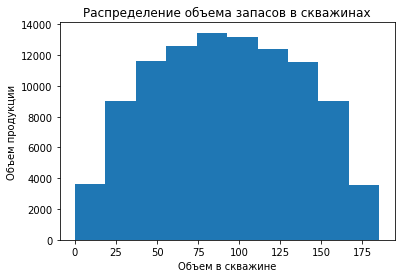

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


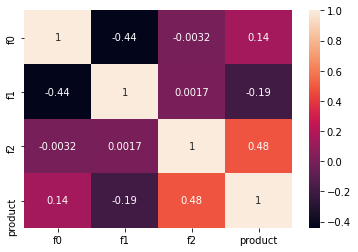

'Исследование данных в Регионе 2'

'выведу первые 5 строк датасета, убедиться что файл прочитался корректно'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


'Посмотрю информацию о датасете, какие данные содержатся, типы, количество значений в каждом столбце и наличие пропусков'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

'Выведу основные статистические метрики по данным'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


'Количество явных дубликатов 0'

'Общий запас продукции в скажинах по региону 6882500.0'

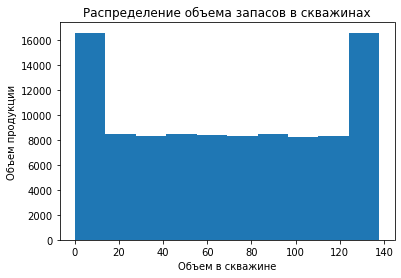

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


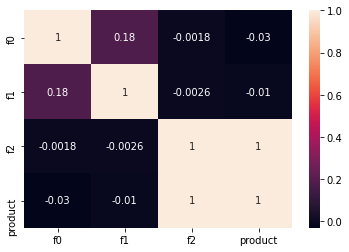

'Исследование данных в Регионе 3'

'выведу первые 5 строк датасета, убедиться что файл прочитался корректно'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


'Посмотрю информацию о датасете, какие данные содержатся, типы, количество значений в каждом столбце и наличие пропусков'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

'Выведу основные статистические метрики по данным'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


'Количество явных дубликатов 0'

'Общий запас продукции в скажинах по региону 9500000.0'

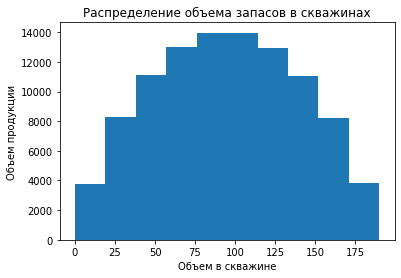

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


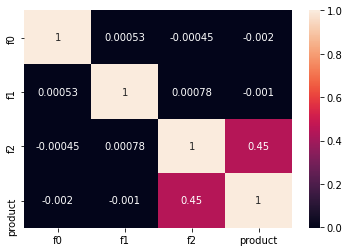

In [133]:
for i in range(len(df)):  
    display(f"Исследование данных в Регионе {i+1}")  
    precheck(df[i],'product')

**Вывод по анализу данных:**

Данные в датасетах состоят из id скважины, признаков **f1, f2 f3** и **объема добычи.**
______________________________________________________
Для **Региона 1:**  
Средний объем добычи в скважинах **92,5 тыс баррелей,**  
Медиана **91,8 тыс баррелей.**  
Минимальный объем – **0**, максимальный **185, 3 тыс баррелей.**  

Общий объем запасов в скважинах **Региона 1** - **9 250 000 тыс баррелей.**  

Построили матрицу корреляции для **Региона 1**:  
- корреляция между признаками **отсутствует,**  
- имеется слабая прямая корреляция признака f2 с целевым признаком – объемом сырья в скважинах **равная 0,48.**  
______________________________________________________

Для **Региона 2:**  
Средний объем добычи в скважинах **68,8 тыс баррелей,**  
Медиана **57,0 тыс баррелей.**  
Минимальный объем – **0**, максимальный **137,9 тыс баррелей.**  

Общий объем запасов в скважинах **Региона 2** - **6 882 500 тыс баррелей.**  

Построили матрицу корреляции для **Региона 2**:  
- корреляция между признаками отсутствует,  
- имеется сильная прямая корреляция признака f2 с целевым признаком – объемом сырья в скважинах равная 0,99.  
______________________________________________________
Для **Региона 3:**  
Средний объем добычи в скважинах **95 тыс баррелей,**  
Медиана **94,9 тыс баррелей.**  
Минимальный объем – **0**, максимальный **190,0 тыс баррелей.**  

Общий объем запасов в скважинах **Региона 3** - **9 500 000 тыс баррелей.**  

Построили матрицу корреляции для **Региона 3**:  
- корреляция между признаками отсутствует,  
- имеется слабая прямая корреляция признака f2 с целевым признаком – объемом сырья в скважинах равная 0,44.



Напишем функцию **PREPARE**, которая будет разделять признаки и целевой признак.  
Сохраним в словари **features и target**, где каждому региону будут соответствовать признаки по индексу.

In [134]:
def prepare(data):
    features = {}
    target = {}
    for i in range(len(data)):
        features[i] = data[i].drop(['id','product'], axis=1)
        target[i] = data[i]['product']
    return features,target

In [135]:
features, target = prepare(df)

Напишем функцию **SHARE**, на вход поступают признаки и целевой признак.  
Функция будет разбивать поступившие данные на тренировочную и валидационную выборку.  
Сохраним данные для тренировочной выборки в **feature_train и target_train,**  
для валидационной выборки в **features_valid и target_valid.**  
Реализуем хранение через словари, чтобы собрать все данные в одной переменной.

In [136]:
def share(features, target):
    feature_train = {}
    target_train = {}
    features_valid = {}
    target_valid = {}
    state = RandomState(12345)
    for i in range(len(target)):
        feature_train[i], features_valid[i], target_train[i], target_valid[i] = train_test_split(features[i], target[i], test_size=0.25, random_state=state)
    return feature_train, features_valid, target_train, target_valid

In [137]:
feature_train, features_valid, target_train, target_valid = share(features,target)

## Обучение и проверка модели

Напишем функцию **STUDY_MODEL**, на вход поступают тренировочные и валидационные выборки разбитые на признаки и целевой признак.  
Внутри функции создается модель линейной регрессии, которая для каждого региона обучается на тренировочных данных и делает предсказание на валидационных.  
Функция возвращает два словаря:
- предсказания для каждого региона;
- RMSE для каждого региона


In [138]:
predict = {} # для хранения предсказаний
result = {} # для хракнения RSME

In [139]:
def study_model(feature_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(feature_train, target_train)
    predict = pd.Series(model.predict(features_valid), index = target_valid.index)
    result = mean_squared_error(target_valid, predict)**0.5
    return predict, result

Сохраним в словари **predict** предсказания, в **result** RMSE для каждого региона

In [140]:
for i in range(len(df)):
    predict[i], result[i] = study_model(feature_train[i], target_train[i], features_valid[i], target_valid[i])
    display(f'Средний запас предсказанного сырья для {i+1} региона {predict[i].mean()}. RMSE модели равна {result[i]}.')

'Средний запас предсказанного сырья для 1 региона 92.59256778438035. RMSE модели равна 37.5794217150813.'

'Средний запас предсказанного сырья для 2 региона 68.76995145799754. RMSE модели равна 0.889736773768065.'

'Средний запас предсказанного сырья для 3 региона 95.087528122523. RMSE модели равна 39.958042459521614.'

Выводы по блоку:  
Наибольшее среднее запасов сырья в третьем регионе, но ошибка модели самая большая 39,95.
Наименьшее среднее запасов во втором регионе. Но ошибка минимальна 0,88. Модель меньше ошибалась, т.к. у целевого признака прямая корреляция с признаком **"f2"**.

## Подготовка к расчёту прибыли

Сохраним константы для дальшейших расчетов

In [141]:
# Бюджет на разрабоку
INVEST = 10000000000

In [142]:
# доход от одной тысячи баррелей нефти
ONE_BAR = 450_000

In [143]:
# количество скважин, которые нужно выбрать
COL_BOREHOLE = 200

In [144]:
# количество скважин для выборки, из которых далее выбираем лучшие 200
TOTAL_BOREHOLE = 500

In [145]:
# минимальный средний уровень запаса в скважине, чтобы разработка не была убыточной
min_product = INVEST/ONE_BAR/COL_BOREHOLE
min_product

111.11111111111111

Минимальный средний объем запаса в скважине должен быть более **111.11 тыс барелей**, чтобы при отборе 200 скважин для разработки мы гарантированно окупили выделяемый бюджет в **10 млрд рублей.**

Напишем функцию **profit.**  
На вход поступают целевой признак и предсказание.  
Далее эти данные объединяем в один датасет, чтобы не возникало несколько одинаковых строк с повторяющимися индексами.
Функция отбирает 200 наилучших скважин по предсказаниям, суммирует доход от имеющихся в них фактических запасов и вычитается бюджет, выделяемый на разработку скважин.
Фунцкия возвращает значение прибыли на рассмотренных 200 "лучших" скважинах.

In [146]:
def profit(target, predict):
    temp_data = pd.DataFrame(columns=['target','predict'])
    temp_data['target']=pd.Series(target).reset_index(drop=True)
    temp_data['predict']=pd.Series(predict).reset_index(drop=True)
    temp_data.sort_values('predict', ascending=False, inplace=True)
    selected = temp_data['target'][:COL_BOREHOLE]
    selected_profit = (selected.sum()*ONE_BAR)-INVEST
    return selected_profit

## Расчёт прибыли и рисков 

Создадим словари:
- прибыль
- количество убыточных скважин
- доверительные интервалы

In [147]:
final_profit = {}
count_loss = {}
confidence_interval = {}
lower = {}
upper = {}

Напишем цикл по регионам.  
В цикле, используя технику **Bootstrap**, 1000 раз разбиваем выборку целевого признака валидационной выборки региона на подвыборки размером 500 скважин с повторением.  
Отбираем предсказания для этого региона, соответствубщие индексам из целевого признака и передаем эти выборки в функцию **revenue.**  

После этого сохраняем значения прибыли для этой подвыборки и считаем сколько раз значение прибыли будет отрицательным, оценивая вероятность убытков.

Также рассчитываем 95% доверительный интервал для среднего значения прибыли.

In [148]:
for region in range(3):
    target_subsample = {}
    predict_subsample = {}
    state = RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample[region] = (target_valid[region].sample(n=TOTAL_BOREHOLE, replace=True, random_state=state))
        predict_subsample[region] = predict[region][target_subsample[region].index]
        values.append(profit(target_subsample[region], predict_subsample[region]))
    final_profit[region] = pd.Series(values)
    count_loss[region] = ((final_profit[region]<0).sum())/(len(final_profit[region]))
    confidence_interval[region] = st.t.interval(0.95, len(final_profit[region])-1,final_profit[region].mean(), pd.Series(final_profit[region]).sem())
    lower[region] = final_profit[region].quantile(0.025)
    upper[region] = final_profit[region].quantile(0.975)

In [149]:
for i in range(len(final_profit)):  
    print('Для региона',  i+1)
    print('Средняя прибыль равна', "{:,}".format(final_profit[i].mean().round(1)),'млн рублей')
    print('95% доверительный интервал для прибыли', i+1, 'от', "{:,.1f}".format(lower[i]/1_000_000), 'до', "{:,.1f}".format(upper[i]/1_000_000), 'млн рублей')
    print('Вероятность получить убытки', '{:.1f}%'.format(count_loss[i]*100))
    print()

Для региона 1
Средняя прибыль равна 396,164,984.8 млн рублей
95% доверительный интервал для прибыли 1 от -111.2 до 909.8 млн рублей
Вероятность получить убытки 6.9%

Для региона 2
Средняя прибыль равна 445,617,552.6 млн рублей
95% доверительный интервал для прибыли 2 от 54.6 до 833.1 млн рублей
Вероятность получить убытки 1.1%

Для региона 3
Средняя прибыль равна 340,026,904.2 млн рублей
95% доверительный интервал для прибыли 3 от -208.0 до 868.9 млн рублей
Вероятность получить убытки 10.7%



Вывод по блоку:  
В результате исследования получили, что наилучший регион для разработки новых скважин - **Регион 2**, т.к. данный регион имеет наибольшую среднюю прибыль:
- на 12,4% больше чем в первом регионе;
- на 31,0% больше чем в третьем регионе.

В **Регионе 2** вероятность получить убыток в результате разработки новых скважин равна 1.1%, что является наименьшим показателем и подходит под требование проекта, в других регионах:  
- в **Регионе 1** вероятность получить убытки равна 6,9%;
- в **Регионе 3** вероятность получить убытки равна 10,7%.

## Вывод по проекту

В нашем распоряжении были данные проб нефти в трех регионах, в каждом из которых **10 000 месторождений.**   
По каждому месторождению имеются данные по качеству нефти и по объему ее запасов.  

Выделяемый бюджет - **10 млрд рублей;**  
Количество скважин для разработки - **200 скважин;**  
Стоимость одного барреля сырья - **450 рублей.**  

Необходимо построить модель машинного обучения, которая позволит определить в каком регионе добыча нефти принесет наибольшую прибыль. 
Также необходимо учитывать, что при выборе региона вероятность убытков не должна превышать **2,5%.**
____________________________________________
В ходе выполнения проекта, первоначально, я загрузил данные для трех регионов и сохранил их в словарь для удобства дальнейшей работы с ними. 
Убедился в том, что данные корректно загрузились, посмотрел размерность, типы данных в датасете и вывел основные статистические параметры датасета.  
____________________________________
Далее я создал функцию **PRECHECK.**    
На вход функции поступают две переменные: датасет=данные одного региона и название целевого признака.  
Функция предназначена для следующих действия для поступающего датасета:  
•	Выведет первые 5 строк датасета на экран, чтобы убедиться в корректности прочитанных данных;  
•	Выведет информацию о датасете: какие данные содержатся, типы, количество значений в каждом столбце и наличие пропусков;  
•	Выведет основные статистические метрики по датасету;  
•	Проверит наличие полных дубликатов;  
•	Выведет общий запас продукции в скажинах в данном регионе;  
•	Построит распределение объема продукции в данном регионе;  
•	Выведет и построит тепловую карту матрицы корреляции признаков;  

В результате работы функции я получил:  
Данные в датасетах состоят из id скважины, признаков **f1, f2 f3** и объема добычи.  
____________________________________
Для **Региона 1**:
Средний объем добычи в скважинах 92,5 тыс баррелей,  
Медиана 91,8 тыс баррелей.
Минимальный объем – 0, максимальный 185, 3 тыс баррелей.

Общий объем запасов в скважинах **Региона 1** - 9 250 000 тыс баррелей.

Построил матрицу корреляции для **Региона 1**:
- корреляция между признаками не выявлена,
- выявлена слабая прямая корреляция признака f2 с целевым признаком – объемом сырья в скважинах равная 0,48.

____________________________________
Для **Региона 2**:
Средний объем добычи в скважинах 68,8 тыс баррелей,  
Медиана 57,0 тыс баррелей.
Минимальный объем – 0, максимальный 137,9 тыс баррелей.

Общий объем запасов в скважинах **Региона 2** - 6 882 500 тыс баррелей.

Построил матрицу корреляции для **Региона 2**:
- корреляция между признаками не выявлена,
- выявлена сильная прямая корреляция признака f2 с целевым признаком – объемом сырья в скважинах равная 0,99.
____________________________________
Для **Региона 3**:
Средний объем добычи в скважинах 95 тыс баррелей,  
Медиана 94,9 тыс баррелей.
Минимальный объем – 0, максимальный 190,0 тыс баррелей.

Общий объем запасов в скважинах **Региона 3** - 9 500 000 тыс баррелей.

Построил матрицу корреляции для **Региона 3**:
- корреляция между признаками не выявлена,
- выявлена слабая прямая корреляция признака f2 с целевым признаком – объемом сырья в скважинах равная 0,44.
____________________________________
Написал функцию **PREPARE**, которая разделяет признаки и целевой признак.  
Сохранил данные в словари **features и target**, где каждому региону будут соответствовать признаки по индексу.

Далее написал функцию **SHARE**, на вход поступают признаки и целевой признак.  
Функция разбивет поступившие данные на тренировочную и валидационную выборку.  
Сохранил данные:
- для тренировочной выборки в **feature_train и target_train,**  
- для валидационной выборки в **features_valid и target_valid.**  

Реализовал хранение через словари, чтобы собрать все данные в одной переменной.
____________________________________
Для обучение модели написал функцию **STUDY_MODEL**, на вход поступают тренировочные и валидационные выборки разбитые на признаки и целевой признак.  
Внутри функции создается модель линейной регрессии, которая для каждого региона обучается на тренировочных данных и делает предсказание на валидационных.  
Функция возвращает два словаря:
- предсказания для каждого региона;
- RMSE для каждого региона

В результате работы функции получил:  
**Для Региона 1** средний объем предсказанного сырья 92.5. RMSE модели равна 37.5  
**Для Региона 2** средний запас предсказанного сырья 68.7. RMSE модели равна 0.88;  
**Для Региона 3** средний запас предсказанного сырья 95.0. RMSE модели равна 39.95

Наибольшее среднее количество запасов сырья в третьем регионе, но ошибка модели самая большая 39,95.  
Наименьшее среднее количество запасов во втором регионе. Но ошибка минимальна 0,88. Модель меньше ошибалась, т.к. у целевого признака прямая корреляция с признаком **"f2"**.
____________________________________
Далее сохранил константы:
- Бюджет на разрабоку 10 млрд рублей;
- Доход от одной тысячи баррелей нефти 450 000 рублей;
- Количество скважин, которые нужно выбрать для разработки, равно 200;
- Количество скважин для выборки, из которых далее выбираем лучшие 200, равно 500.

Рассчитал минимальный средний объем запаса в скважине должен быть более **111.11 тыс барелей**, чтобы при отборе 200 скважин для разработки мы гарантированно окупили выделяемый бюджет в **10 млрд рублей.**
____________________________________
Далее я написал функцию **revenue.**  
На вход функции поступают целевой признак и предсказание.  
Функция отбирает 200 наилучших скважин по предсказаниям, суммирует доход от имеющихся в них фактических запасов и вычитается бюджет, выделяемый на разработку скважин.
Фунцкия возвращает значение прибыли на рассмотренных 200 "лучших" скважинах.
____________________________________
В цикле по регионам, используя технику **Bootstrap**, я 1000 раз разбил валидационную выборку целевого признака региона на подвыборки размером 500 скважин с "повторением".  
Отбирая предсказания для этого региона, соответствующие индексам из целевого признака и передавая эти выборки в функцию **revenue** рассчитывал среднее значение прибыли для каждой подвыборки. 

После этого сохранял значения прибыли для этой подвыборки и считал сколько раз значение прибыли получилось отрицательным, для оценки вероятности убытков.

Также рассчитывал 95% доверительный интервал для среднего значения прибыли.
____________________________________
В результате работы функции получил:
 **Регион 1:**
- средняя прибыль равна **396,164,984.8;** 
- вероятность убытков 6,9%;
- доверительный интервал: -111.2 до 909.8 млн рублей;

 **Регион 2:**
- средняя прибыль равна **445,617,552.6;** 
- вероятность убытков 1,1%;
- доверительный интервал: 54.6 до 833.1 млн рублей;

 **Регион 3:**
- средняя прибыль в **Регионе 3 равна 340,026,904.2;**
- вероятность убытков 10,7%.
- доверительный интервал: -208.0 до 868.9 млн рублей.
____________________________________ 
В результате исследования я получил, что наилучший регион для разработки новых скважин - **Регион 2**, т.к. данный регион имеет наибольшую среднюю прибыль:
- на 12,4% больше чем в первом регионе;
- на 31,0% больше чем в третьем регионе.

В **Регионе 2** вероятность получить убыток в результате разработки новых скважин равна 1,1%, что является наименьшим показателем и подходит под требование проекта, в других регионах:  
- в **Регионе 1** вероятность получить убытки равна 6,79;
- в **Регионе 3** вероятность получить убытки равна 10,7%.
